In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import torch
import torch.nn as nn
import torch.optim as optim
import os

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet18,googlenet, densenet121,mobilenet_v3_small,mobilenet_v3_large
from sklearn.model_selection import train_test_split
from PIL import Image

def multiple_dir_files_to_df(dirs, label):
    df = pd.DataFrame()
    for idx,dir in enumerate(dirs):
        files = os.listdir(dir)
        files = [dir + '/' + file for file in files]
        df = pd.concat([df,pd.DataFrame({'file': files, 'label': label[idx]})])
    return df

common_path="Image/"

labels=["neutral","happy","sad","fear","angry","surprise","disgust"]
full_labels =["neutral","happy","sad","fear","angry","surprise","disgust","Happily_Surprised",
"Happily_Disgusted","Sadly_Fearful","Sadly_Angry","Sadly_Surprised","Sadly_Disgusted",
"Fearfully_Angry","Fearfully_Surprised","Fearfully_Disgusted","Angrily_Surprised",
"Angrily_Disgusted","Disgustedly_Surprised","Appalled","Hatred","Awed"]

database=[common_path+label for label in labels]
database_full=[common_path+label for label in full_labels]

def training_test_model(train_loader, val_loader, test_loader, model,model_name,epochs=50, learning_rate=0.001,weight_decay=1e-4,gamma=0.9,early_stopping_patience=5,early_stopping_save=True):
    # Initialiser le modèle et le journal
    model = model
    patience = early_stopping_patience
    best_val_loss = float('inf')
    counter = 0
    accuracy_val_list=[]
    accuracy_train_list=[]
    loss_val_list=[]
    loss_train_list=[]
    
    # Entraîner le modèle
    num_epochs = epochs
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Définir l'optimiseur et la fonction de perte
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma=gamma)
    # Entraîner le modèle
    for epoch in range(num_epochs):
        accuracy_train=[]
        loss_train=[]
        accuracy_val=[]
        loss_val=[]
        accuracy_test=[]
        loss_test=[]
        current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]

        model.train()
        for batch_idx, (data, targets) in enumerate(train_loader):
            # Get data to cuda if possible
            data = data.to(device=device)
            targets = targets.to(device=device)

            # forward
            scores = model(data)
            loss = criterion(scores, targets.long())

            # backward
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            likelihood, predictions = scores.max(1)
            loss_train.append(loss.item())
            accuracy_train.append((predictions == targets).float().mean().item())

            # gradient descent or adam step
        scheduler.step()

        model.eval()
        for batch_idx, (data, targets, _) in enumerate(val_loader):
            # Get data to cuda if possible
            data = data.to(device=device)
            targets = targets.to(device=device)

            # forward
            scores = model(data)
            loss = criterion(scores, targets.long())
            
            likelihood, predictions = scores.max(1)
            loss_val.append(loss.item())
            accuracy_val.append((predictions == targets).float().mean().item())

        #testing the model
        for batch_idx, (data, targets, _)  in enumerate(test_loader):
            # Get data to cuda if possible
            data = data.to(device=device)
            targets = targets.to(device=device)

            # forward
            scores = model(data)
            loss = criterion(scores, targets.long())
            
            likelihood, predictions = scores.max(1)
            loss_test.append(loss.item())
            accuracy_test.append((predictions == targets).float().mean().item())

        accuracy_train=np.array(accuracy_train).mean()
        loss_train=np.array(loss_train).mean()
        accuracy_val=np.array(accuracy_val).mean()
        loss_val=np.array(loss_val).mean()
        accuracy_test=np.array(accuracy_test).mean()
        loss_test=np.array(loss_test).mean()
        accuracy_val_list.append(accuracy_val)
        accuracy_train_list.append(accuracy_train)
        loss_val_list.append(loss_val)
        loss_train_list.append(loss_train)
        
        if early_stopping_save:
            if loss_val < best_val_loss:
                best_val_loss = loss_val
                best_val_accuracy = accuracy_val
                counter = 0
                best_params = model.state_dict()
            else:
                counter += 1
            if counter > patience:
                print("Early stopping at epoch: ",epoch)
                print("Saving model...")
                saved_params = model.state_dict()
                # get percentage of accuracy
                best_val_accuracy = np.round(best_val_accuracy*100,0)
                torch.save(saved_params, f"./models_tg/{model_name}_{str(int(best_val_accuracy))}.pth")
                return accuracy_val_list,accuracy_train_list,loss_val_list,loss_train_list
        print(f"Train epoch: {epoch}, accuracy = {accuracy_train} ,loss = {loss_train}, lr = {np.round(current_lr,6)}")
        print(f"val epoch: {epoch}, accuracy = {accuracy_val} ,loss = {loss_val}")
        print(f"test epoch: {epoch}, accuracy = {accuracy_test} ,loss = {loss_test}")

    
    torch.save(model.state_dict(), f"./models/{model_name}.pth")
    return accuracy_val_list,accuracy_train_list,loss_val_list,loss_train_list

def plot_train_loss(accuracy_test_list,accuracy_train_list,loss_test_list,loss_train_list,model_name):
    plt.figure(figsize=(10,5))
    plt.plot(accuracy_test_list,label="accuracy_test")
    plt.plot(accuracy_train_list,label="accuracy_train")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy for "+model_name+" model")
    plt.legend()
    plt.figure(figsize=(10,5))
    plt.plot(loss_test_list,label="loss_test")
    plt.plot(loss_train_list,label="loss_train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss for "+model_name+" model")
    plt.legend()


df = multiple_dir_files_to_df(database,np.linspace(0,6,7))
X,y=df["file"].tolist(),df["label"].tolist()

#Split the dataset into train and test
df_full = multiple_dir_files_to_df(database_full,np.linspace(0,21,22))
X_full,y_full=df_full["file"].tolist(),df_full["label"].tolist()


X_train_full,X_test_full,y_train_full,y_test_full = train_test_split(X_full,y_full,test_size=0.1, random_state=42)

#get data with labels
X_train = [X_train_full[i] for i in range(len(X_train_full)) if int(y_train_full[i]) < 7]
y_train = [y_train_full[i] for i in range(len(y_train_full)) if int(y_train_full[i]) < 7]

X_test = [X_test_full[i] for i in range(len(X_test_full)) if int(y_test_full[i]) < 7]
y_test = [y_test_full[i] for i in range(len(y_test_full)) if int(y_test_full[i]) < 7]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print("Train head: ",X_train[:5],"\n",y_train[:5])
print("Test head: ",X_test[:5],"\n",y_test[:5])

# Définir un Dataset personnalisé
# Définir un Dataset personnalisé
class CustomDataset(Dataset):
    def __init__(self, file_names, labels,  transform=None):
        self.file_names = file_names
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_path = f'{self.file_names[idx]}' 
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        image, label = image.to(device), label.to(device)


        return image, label, self.file_names[idx]

# Define the image transformations
train_transform = transforms.Compose([
    transforms.CenterCrop((500, 500)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.CenterCrop((500, 500)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
# Créer les jeux de données et les chargeurs de données
train_dataset = CustomDataset(X_train, y_train, transform=train_transform)
val_dataset = CustomDataset(X_val, y_val, transform=train_transform)
test_dataset = CustomDataset(X_test, y_test, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class MobileNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.mobilenet = mobilenet_v3_small(weights='IMAGENET1K_V1')
        self.mobilenet.classifier[3] = nn.Linear(1024, 7)
    def forward(self, x):
        return self.mobilenet(x)

Train head:  ['Image/angry/05_131.jpg', 'Image/happy/02_141.jpg', 'Image/happy/02_081.jpg', 'Image/angry/05_216.jpg', 'Image/happy/02_148.jpg'] 
 [4.0, 1.0, 1.0, 4.0, 1.0]
Test head:  ['Image/surprise/06_106.jpg', 'Image/neutral/01_080.jpg', 'Image/neutral/01_229.jpg', 'Image/neutral/01_066.jpg', 'Image/disgust/07_147.jpg'] 
 [5.0, 0.0, 0.0, 0.0, 6.0]


In [2]:
aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

In [14]:
set(y_full)

{0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0}

In [15]:
au = pd.read_csv(f"../AU_models/dataset/Database.csv")
dataset = CustomDataset(X_full, y_full, transform=aug_transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [86]:
random_string="".join([str(np.random.randint(0,9)) for i in range(6)])

In [87]:
random_string

'316683'

In [ ]:
train_trans

NameError: name 'data' is not defined

Image/neutral/01_214.jpg


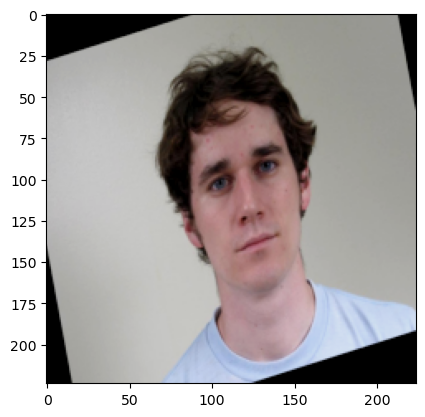

In [77]:

df_aug = pd.DataFrame()
for batch_idx, (data, targets, filename) in enumerate(loader):
    print(filename[0])
    for i in range(len(data)):
        #save the image
        img = data[i].permute(1,2,0).numpy()
        label = filename[i].split('/')[1]
        img_name = filename[i].split('/')[-1].split('.')[0] + "_" + random_string + ".jpg"

        plt.imsave(f"database_aug/{img_name}",img)

In [17]:
base_transform = transforms.Compose([
    transforms.Resize((750, 1000)),
    transforms.ToTensor(),
])

In [18]:
class baseDataset(Dataset):
    def __init__(self, file_names, labels,  transform=None):
        self.file_names = file_names
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_path = f'{self.file_names[idx]}' 
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        filename = torch.tensor(self.file_names[idx], dtype=torch.str)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        image, label = image.to(device), label.to(device)


        return image, label, filename

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.1, random_state=42)

dataset_train = CustomDataset(X_train, y_train, transform=base_transform)
loader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_test = CustomDataset(X_test, y_test , transform=base_transform)
loader_test = DataLoader(dataset_test, batch_size=32, shuffle=True)

In [9]:
len(X_full)

5060

In [11]:
labels = []
img_names = []

df_train = pd.DataFrame()
for batch_idx, (data, targets, filename) in enumerate(loader_train):
    for i in range(len(data)):
        #save the image
        img = data[i].to("cpu").permute(1,2,0).numpy()
        label = filename[i].split('/')[1]
        img_name = filename[i].split('/')[-1].split('.')[0] + ".jpg"
        plt.imsave(f"database_train/{img_name}",img)
        labels.append(label)
        img_names.append(img_name)
df_train["filenames"] = img_names
df_train["labels"] = labels
df_train.to_csv("database_train.csv",index=False)

In [16]:
labels = []
img_names = []

df_test = pd.DataFrame()
for batch_idx, (data, targets, filename) in enumerate(loader_test):
    for i in range(len(data)):
        #save the image
        img = data[i].to("cpu").permute(1,2,0).numpy()
        label = filename[i].split('/')[1]
        img_name = filename[i].split('/')[-1].split('.')[0] + ".jpg"
        plt.imsave(f"database_test/{img_name}",img)
        labels.append(label)
        img_names.append(img_name)
df_test["filenames"] = img_names
df_test["labels"] = labels
df_test.to_csv("database_test.csv",index=False)

In [20]:
aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
])

In [21]:

dataset_aug = CustomDataset(X_train, y_train , transform=aug_transform)
loader_aug = DataLoader(dataset_aug, batch_size=32, shuffle=True)

In [25]:
len(X_test)

506

In [26]:
import string
import random
labels = []
img_names = []
letters = string.ascii_lowercase

df_aug = pd.DataFrame()
for i in range(5):
    for batch_idx, (data, targets, filename) in enumerate(loader_aug):
        for i in range(len(data)):
            #save the image
            img = data[i].to("cpu").permute(1,2,0).numpy()
            label = filename[i].split('/')[1]
            img_name = filename[i].split('/')[-1].split('.')[0]
            random_string="".join([str(random.choice(letters)) for i in range(10)])
            img_name = img_name + "_" + random_string + ".jpg"
            plt.imsave(f"database_aug/{img_name}",img)
            labels.append(label)
            img_names.append(rf"{img_name}")


In [28]:
df_aug.shape

(22770, 2)

In [29]:
df_aug["filenames"] = img_names
df_aug["labels"] = labels
df_aug.to_csv("database_aug.csv",index=False)

In [30]:
set(labels)

{'Angrily_Disgusted',
 'Angrily_Surprised',
 'Appalled',
 'Awed',
 'Disgustedly_Surprised',
 'Fearfully_Angry',
 'Fearfully_Disgusted',
 'Fearfully_Surprised',
 'Happily_Disgusted',
 'Happily_Surprised',
 'Hatred',
 'Sadly_Angry',
 'Sadly_Disgusted',
 'Sadly_Fearful',
 'Sadly_Surprised',
 'angry',
 'disgust',
 'fear',
 'happy',
 'neutral',
 'sad',
 'surprise'}